In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

In this notebook, we utilize a grid environment to train an agent via *Q-learning*. The resulting policy $\pi^*$ derived from $Q_{\pi^*}$ is then used to produce noisiliy-rational behaviours. These behaviours, also known as *demonstrations*, originates from a Boltzmann-model $\pi_{boltz}$:

$$ \pi_{boltz}(a_t|s_t) = \frac{e^{Q_{\pi^*}(s,a)/\tau}}{\sum_{a'\in\mathbf{A}}e^{Q_{\pi^*}(s,a')/\tau}} $$

In [4]:
def ind2sub(shape,s):
    return s[0]*shape + s[1]

def sub2ind(shape,i):
    return [i//shape,i%shape]

def action2str(demo):
    #Turn action index into str
    res=[]
    for i in demo:
        if i==0:
            res.append("North")
        elif i==1:
            res.append("West")
        elif i==2:
            res.append("South")
        else :
            res.append("East")
            
    return res
            
        

In [208]:
class grid:

    def __init__(self,s):
        #Initialization of the grid environment and the q_learning objects and parameters
        self.size = s
        self.tab = np.zeros((self.size[0],self.size[1]))
        self.start = [0,0]
        self.end = [self.size[0],self.size[1]]
        self.state = self.start
        self.q_table = np.zeros((4,self.size[0]*self.size[1]))
        self.discount=0.99
        self.lr = 0.1
        self.epsilon=0.1
    
    
    
    ## Creation of the maze ##
    def add_end(self,s):
        if not(s==self.start):
            self.tab[s[0],s[1]] = 10
            self.end = s
            
        else:
            print("This position corresponds to the starting point!")
        
    
    def add_safe(self,s):
        if not(s==self.start):
            self.tab[s[0],s[1]] = 0
        else:
            print("This position corresponds to the starting point!")
        
    def add_danger(self,s):
        if not(s==self.start):
            self.tab[s[0],s[1]] = -2
        else:
            print("This position corresponds to the starting point!")
     
    
    
    ## State modification and display ##
    
    def step(self,o):
        
        new_s=[self.state[0],self.state[1]]
        
        if self.start==self.end:
            return self.end,10,True
        
        if o==0 and new_s[0]-1>=0: #North
            new_s[0]-=1
        elif o==1 and new_s[1]-1>=0: #West
            new_s[1]-=1
        elif o==2 and new_s[0]+1<self.size[0]:#South
            new_s[0]+=1
        elif o==3 and new_s[1]+1<self.size[1]:#East
            new_s[1]+=1
       
        
        if new_s==self.state:
            return self.state, 0, False
        
        else:
            #if proceed:
                #self.state = new_s
            
            return new_s, self.tab[new_s[0],new_s[1]], new_s==self.end
    
    # Random reset of the environment, e.g, for the q-learning
    def rand_reset(self):
        self.start=sub2ind(self.size[1],np.random.randint(0,self.size[0]*self.size[1]))
        self.state=[self.start[0],self.start[1]]
      
    # Reset at a specific position, e.g, for comparaison of noisy-rational demonstration
    def reset(self,start):
        self.start=start
        self.state=start

    
    def print_env(self):
        for i in range(self.size[0]):
            for j in range(self.size[1]):
                if (np.array([i,j])==self.state).all():
                    print("@",end="   ")
                elif (np.array([i,j])==self.start).all():
                    print("-",end="   ")
                elif self.tab[i,j]==10:
                    print("0",end="   ")
                elif self.tab[i,j]==0:
                    print("x",end="   ")
                else:
                    print("!",end="   ")
                    
            print("\n")
            
    
    
    ## Q-learning ##
    
    def update_q(self,a,s,s1,r,done):
        
        #print(s,s1,a)
        s = ind2sub(self.size[1],s)
        s1 = ind2sub(self.size[1],s1)
        
        if done:
            td = r - self.q_table[a,s]
            #print("IN")
        else:
            td = r + self.discount*np.max(self.q_table[:,s1]) - self.q_table[a,s]
        
        self.q_table[a,s] = self.q_table[a,s] + self.lr*td
        
        return td
        
        
    def q_learning(self,limit_step,nb_episode):

        self.q_table = np.zeros((4,self.size[0]*self.size[1]))
        n_step=[]
        err_=[]
        
        init_lr = self.lr
        
        for e in tqdm(range(nb_episode+1)):
            k=0
            done=False
            self.rand_reset()
            
            while k<limit_step and not(done):

                if self.start==self.end:
                    pass
                    
                epsi = np.random.rand(1)[0]
                if epsi < self.epsilon:
                    action = np.random.randint(0,4)
                else:
                    #ind_max = np.where(self.q_table[:,ind2sub(self.size[1],self.state)]==np.max(self.q_table[:,ind2sub(self.size[1],self.state)]))[0]
                    #action = np.random.choice(ind_max)
                    action = np.argmax(self.q_table[:,ind2sub(self.size[1],self.state)])
                    
                [new_state, reward, done] = self.step(action)
                #print(self.state,new_state,action)
                err = self.update_q(action,self.state,new_state,reward,done)
                
                self.state = new_state
                k+=1
                err_.append(abs(err))

            n_step.append(k)

        
        return n_step, err_
    
    
    ## Noisily-rational behaviour generation ##
    
    def boltz_rational_noisy(self,tau,n,start_):
        # Tau : temperature coefficient 
        # n : number of demonstrations generated from the same start
        
        self.reset(start_)
        a=[]
        for demo in range(n):
            done=0
            a.append([])
            while not(done):
                if env1.start==env1.end:
                    break
                actions=self.q_table[:,ind2sub(self.size[1],self.state)]
                boltz_distribution = np.exp(actions/tau)/np.sum(np.exp(actions/tau))
                noisy_behaviour = np.random.choice([0,1,2,3],p=boltz_distribution)
                [new_state,reward,done] = self.step(noisy_behaviour)
                self.state=new_state
                a[demo].append(noisy_behaviour)
            a[demo] = np.array(a[demo])
            self.reset(self.start)
        return a, self.start

    
    def any_traj(self):
    
        for k in range(self.size[0]*self.size[1]):
            self.start=sub2ind(self.size[1],k)
            self.state=self.start
            done=False
            it=0
            action_=[]
            new_state=self.start
            while not(done) and it<100:
                if self.start==self.end:
                    break
                action = np.argmax(self.q_table[:,ind2sub(self.size[1],new_state)])
                [new_state, reward, done] = self.step(action)
                self.state=new_state
                #print(new_state)
                it+=1
                action_.append(action)
            print("Start ",self.start,"->",it,"iterations",action2str(action_))

Initialization and boundary conditions testing

In [209]:
env1 = grid([6,7])
env1.add_end([2,5])
env1.add_danger([1,1])
env1.add_danger([0,1])
env1.add_danger([1,0])
env1.add_danger([1,3])
env1.add_danger([2,3])
env1.add_danger([5,3])
env1.add_danger([4,3])
env1.print_env()

#Test boundary and obstacle conditions
print("Moving to the top...",end=" ")
env1.step(0)
print("Moving to the left...",end=" ")
env1.step(1)
print("Moving to the bottom...",end=" ")
env1.step(2)
print("Moving to the right...",end=" ")
env1.step(3)
print("\n")
env1.print_env()

#Test random reset
env1.rand_reset()
print("\n")
env1.print_env()


@   !   x   x   x   x   x   

!   !   x   !   x   x   x   

x   x   x   !   x   0   x   

x   x   x   x   x   x   x   

x   x   x   !   x   x   x   

x   x   x   !   x   x   x   

Moving to the top... Moving to the left... Moving to the bottom... Moving to the right... 

@   !   x   x   x   x   x   

!   !   x   !   x   x   x   

x   x   x   !   x   0   x   

x   x   x   x   x   x   x   

x   x   x   !   x   x   x   

x   x   x   !   x   x   x   



x   !   x   x   x   x   x   

!   !   x   !   x   x   x   

x   x   x   !   x   0   x   

x   x   @   x   x   x   x   

x   x   x   !   x   x   x   

x   x   x   !   x   x   x   



  0%|          | 0/70002 [00:00<?, ?it/s]

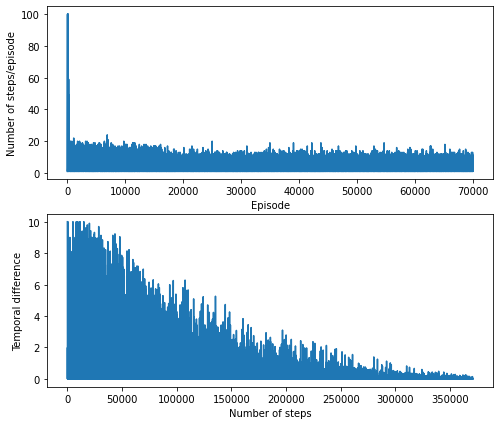

In [223]:
step_, err_ = env1.q_learning(100,70001)

plt.figure(figsize=(8,7))

plt.subplot(211)
plt.plot(step_)
plt.ylabel("Number of steps/episode")
plt.xlabel("Episode")
#plt.title("Number of steps per episode")

plt.subplot(212)
plt.xlabel("Number of steps")
plt.ylabel("Temporal difference")
plt.plot(err_)

plt.show()


After few thousands episodes, the number of steps needed to reach the end tile drastically decreases from 100 steps, the maximum number of allowed steps, to 10 and later 8 steps per episode.

We can also see that the temporal difference $\gamma Q(s',a') + R - Q(s,a)$ slowly decreases, meaning that values in the q-table are reaching their optimal value, or at least, a stable value. 

To asses the performance of the policy $\pi^*$, trajectories from every possible start are display below.
It seems that almost trajectory is optimal, the total number of step is ranging from 0 to 8 for a 6x6 grid. It is also interesting to note that because the end tile is located close to the right boundary, the agent never chooses action "West" 

In [211]:
env1.any_traj()

Start  [0, 0] -> 7 iterations ['East', 'East', 'East', 'East', 'East', 'South', 'South']
Start  [0, 1] -> 6 iterations ['East', 'East', 'East', 'East', 'South', 'South']
Start  [0, 2] -> 5 iterations ['East', 'East', 'East', 'South', 'South']
Start  [0, 3] -> 4 iterations ['East', 'East', 'South', 'South']
Start  [0, 4] -> 3 iterations ['East', 'South', 'South']
Start  [0, 5] -> 2 iterations ['South', 'South']
Start  [0, 6] -> 3 iterations ['West', 'South', 'South']
Start  [1, 0] -> 8 iterations ['North', 'East', 'East', 'East', 'East', 'East', 'South', 'South']
Start  [1, 1] -> 9 iterations ['South', 'East', 'North', 'North', 'East', 'East', 'East', 'South', 'South']
Start  [1, 2] -> 6 iterations ['North', 'East', 'East', 'East', 'South', 'South']
Start  [1, 3] -> 5 iterations ['North', 'East', 'East', 'South', 'South']
Start  [1, 4] -> 2 iterations ['East', 'South']
Start  [1, 5] -> 1 iterations ['South']
Start  [1, 6] -> 2 iterations ['West', 'South']
Start  [2, 0] -> 9 iterations [

In [235]:
n_demo = 5
tau = 0.02

env1.rand_reset()

print("Tau = 0.02")
demonstration,start_=env1.boltz_rational_noisy(tau,n_demo,env1.start)
print("Mean demonstration length =",sum([np.size(s) for s in demonstration ])//n_demo)
env1.reset(env1.start)
env1.print_env()
print("Start =",start_,end="\n\n")
for k in range(n_demo):
    print("  * Demonstration #",k+1,"=",action2str(demonstration[k]))

    
print("\nTau = 0.1")
tau=0.1
demonstration,start_=env1.boltz_rational_noisy(tau,n_demo,env1.start)
print("Mean demonstration length =",sum([np.size(s) for s in demonstration ])//n_demo)
env1.reset(env1.start)
env1.print_env()
print("Start =",start_,end="\n\n")
for k in range(n_demo):
    print("  * Demonstration #",k+1,"=",action2str(demonstration[k]))

print("\nTau = 1")
tau=1
demonstration,start_=env1.boltz_rational_noisy(tau,n_demo,env1.start)
print("Mean demonstration length =",sum([np.size(s) for s in demonstration ])//n_demo)
env1.reset(env1.start)
env1.print_env()
print("Start =",start_,end="\n\n")
for k in range(n_demo):
    print("  * Demonstration #",k+1,"=",action2str(demonstration[k]))

Tau = 0.02
Mean demonstration length = 2
x   !   x   x   x   x   x   

!   !   x   !   x   x   @   

x   x   x   !   x   0   x   

x   x   x   x   x   x   x   

x   x   x   !   x   x   x   

x   x   x   !   x   x   x   

Start = [1, 6]

  * Demonstration # 1 = ['West', 'South']
  * Demonstration # 2 = ['West', 'South']
  * Demonstration # 3 = ['South', 'West']
  * Demonstration # 4 = ['South', 'West']
  * Demonstration # 5 = ['West', 'South']

Tau = 0.1
Mean demonstration length = 4
x   !   x   x   x   x   x   

!   !   x   !   x   x   @   

x   x   x   !   x   0   x   

x   x   x   x   x   x   x   

x   x   x   !   x   x   x   

x   x   x   !   x   x   x   

Start = [1, 6]

  * Demonstration # 1 = ['East', 'South', 'West']
  * Demonstration # 2 = ['South', 'West']
  * Demonstration # 3 = ['South', 'North', 'West', 'South']
  * Demonstration # 4 = ['South', 'North', 'West', 'West', 'South', 'East']
  * Demonstration # 5 = ['North', 'West', 'North', 'South', 'South']

Tau = 1
Mean demon

For $\tau=1$, the model behaves as an expert, i.e., trajectories are identical and optimal.

For $\tau=5$, generated trajectories are slighty different from to another but remain acceptable in terms of length.

For $\tau=50$, there is a huge difference between each generated trajectories, some of them being close to random exploration.

@   x   x   x   x   x   

x   x   x   x   x   x   

x   x   x   !   !   0   

x   x   x   x   !   x   

x   !   !   !   !   x   



  0%|          | 0/50002 [00:00<?, ?it/s]

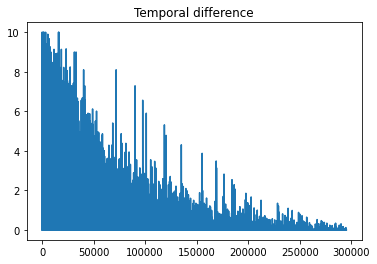

In [243]:
oox = grid([5,6])
oox.add_end([2,5])
oox.add_danger([2,4])
oox.add_danger([2,3])
oox.add_danger([3,4])
oox.add_danger([4,4])
oox.add_danger([4,3])
oox.add_danger([4,2])
oox.add_danger([4,1])

oox.print_env()

step_, err_ = oox.q_learning(50,50001)

plt.plot(err_)
plt.title("Temporal difference")
plt.show()

In [242]:
n_demo = 5
tau = 0.02

oox.rand_reset()

print("Tau = 0.02")
demonstration,start_=oox.boltz_rational_noisy(tau,n_demo,oox.start)
print("Mean demonstration length =",sum([np.size(s) for s in demonstration ])//n_demo)
oox.reset(oox.start)
oox.print_env()
print("Start =",start_,end="\n\n")
for k in range(n_demo):
    print("  * Demonstration #",k+1,"=",action2str(demonstration[k]))
    
print("\nTau = 0.1")
tau=0.1
demonstration,start_=oox.boltz_rational_noisy(tau,n_demo,oox.start)
print("Mean demonstration length =",sum([np.size(s) for s in demonstration ])//n_demo)
oox.reset(oox.start)
oox.print_env()
print("Start =",start_,end="\n\n")
for k in range(n_demo):
    print("  * Demonstration #",k+1,"=",action2str(demonstration[k]))

print("\nTau = 1")
tau=1
demonstration,start_=oox.boltz_rational_noisy(tau,n_demo,oox.start)
print("Mean demonstration length =",sum([np.size(s) for s in demonstration ])//n_demo)
oox.reset(oox.start)
oox.print_env()
print("Start =",start_,end="\n\n")
for k in range(n_demo):
    print("  * Demonstration #",k+1,"=",action2str(demonstration[k]))

Tau = 0.02
Mean demonstration length = 9
x   x   x   x   x   x   

x   x   x   x   x   x   

x   x   x   !   !   0   

x   x   x   x   !   x   

@   !   !   !   !   x   

Start = [4, 0]

  * Demonstration # 1 = ['North', 'West', 'East', 'North', 'North', 'East', 'East', 'East', 'East', 'South']
  * Demonstration # 2 = ['North', 'East', 'East', 'North', 'North', 'East', 'East', 'East', 'South']
  * Demonstration # 3 = ['North', 'East', 'East', 'North', 'North', 'East', 'East', 'East', 'South']
  * Demonstration # 4 = ['North', 'North', 'East', 'East', 'North', 'East', 'East', 'East', 'South']
  * Demonstration # 5 = ['North', 'North', 'East', 'North', 'East', 'East', 'East', 'East', 'South']

Tau = 0.1
Mean demonstration length = 17
x   x   x   x   x   x   

x   x   x   x   x   x   

x   x   x   !   !   0   

x   x   x   x   !   x   

@   !   !   !   !   x   

Start = [4, 0]

  * Demonstration # 1 = ['North', 'North', 'East', 'East', 'South', 'North', 'North', 'East', 'East', 'East', 'S